#  Question 2 - Alex Bercik (1002128020) and Jaewon Yun (999243322)

In [1]:
#import modules
from banded import banded 
from pylab import zeros,exp,linspace,clf, pause,draw,plot,xlim,ylim,show,title,xlabel,ylabel,figure,axes
import scipy.constants as pc
import numpy as np

# Newman 9.8 

In one dimension the schrodinger equation for a particle of mass M with no potential energy reads
\begin{align}
\frac{-\hbar^{2}}{2M}\frac{\partial^2 \psi}{\partial x^2}=i\hbar\frac{\partial \psi}{\partial t}
\end{align}
Put our particle in a box with impenetrable walls, the box forces the wavefunction to be zero at the walls, which we will put at x=0 and x=L. Replacing the second derivative in the shcrodinger equation with a finite difference and applying Euler's method, we get the FTCS equation
\begin{align}
\psi(x,t+h) &= \psi(x,t) +h\frac{i\hbar}{2ma^2}[\psi(x+a,t) + \psi(x-a,t) - 2 \psi(x,t)]
\end{align}
where a is the spacing of the spatial grid points and h is the size of the time step, after performng a similiar step in reverse and taking the average, we get the Crank-Nicolson equation for the schrodinger equation:
\begin{align}
\psi(x,t+h)-h\frac{i\hbar}{4ma^2}[\psi(x+a,t+h) + \psi(x-a,t+h) - 2 \psi(x,t+h) &= \psi(x,t) +h\frac{i\hbar}{4ma^2}[\psi(x+a,t) + \psi(x-a,t) - 2 \psi(x,t)]
\end{align}
this gives us a set of simultaneous equations, ond for each grid point. As Newman says, we will arragne the values of wavefunction at these interior points into a vector, then Crank-Nicolson equation can be written in the form
\begin{align}
A\psi(t+h)=B\psi(t)
\end{align}
And Matrix A and B are both symmetric and tridiagonal given by textbook.
The initial wavefunction at t=0 is defined by
\begin{align}
\psi(x,0) &=\text{exp}\Big[-\frac{(x-x_{0})^2}{2\sigma^2}\Big]e^{ikx}
\\
\text{where} & \ x_{0}=\frac{L}{2},\ sigma=10^{-10}m,\ k=5*10^{10}m^{-1}
\end{align}

# (a)(b)
Write the program to perform the Crank-Nicolson method for electron, using N=1000 spatial slices with a=L/N.
First, given the initial wavefunction and multiply matrix B to get a vector V. The ith component of V is given by 
\begin{align}
v_{i}=b_{i}\psi_{i}+b_{2}(\psi_{i+1}+\psi_{i-1})
\end{align}
Choose the time-step h(=10^-18s)
Second, solve the linear system Ax=v for x, which is the new value of wavefunction using banded.py 

Define constants, initial conditions and initial wavefunction

In [2]:
#Define initial conditions
h = 1e-18  #time step
hbar=pc.hbar #hbar
L = 1e-8 #length of box
M = 9.109e-31 #mass of electron
N = 1000 # Grid slices

a = L/N #define a
#define component of tridiagonal matrix A and B
a1 = 1 + h*hbar*1j/(2*M*(a**2))
a2 =  -h*hbar*1j/(4*M*(a**2))
b1 =  1 -h*hbar*1j/(2*M*(a**2))
b2 =  h*hbar*1j/(4*M*(a**2))
#create array for wavefunction with N element
psi = zeros(N,complex)
#define initial wavefunction at time=0
def inipsi(x):
	x0 = L/2
	sigma = 1e-10
	k = 5e10
	return exp(-(x-x0)**2/(2*(sigma**2)))*exp(1j*k*x)
#assign initial condition to wavefunction and fix the boundary condtition at x=0 and x=L
x = linspace(0,L,N-3)
psi[1:N-2] = inipsi(x)
#create the tridiagonal matrices A and B 
A =np.zeros((3,N),dtype=complex)
A[0,1:]=a2
A[1,:]=a1
A[2,:N-1]=a2
B =np.zeros((3,N),dtype=complex)
B[0,1:]=b2
B[1,:]=b1
B[2,:N-1]=b2

In [3]:
###### Main FTCS LOOP ########
wave = [] # create list to store wavefunctions at each step
Tf=1e-15 # final loop time
t=0 #initial time

x = linspace(0,L,N) #create array for x-axis
v=zeros(N,complex) #create array for vector v

# looping until the desired time
while t<Tf:
    #use the equation for i component of vector v   
    for i in range(1,N-1):
        v[i] = b1*psi[i] + b2*(psi[i+1] + psi[i-1])
    # assign the first component and last component of vector v
    v[0]=psi[0]
    v[N-1]=psi[N-1]
    #solve the vector equation Ax=v  for x using function banded
    psi=banded(A,v,1,1)
    #increase the time by time step h
    t +=h
    wave.append(np.real(psi))

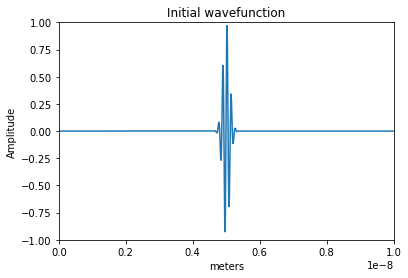

In [4]:
# Plot the wavefunction for t=0 : corresponds to first element of wave
plot(np.linspace(0,1e-8,1000),wave[0])
xlabel('meters')
ylabel('Amplitude')
xlim(0,1e-8)
ylim(-1,1)
title('Initial wavefunction')
show()

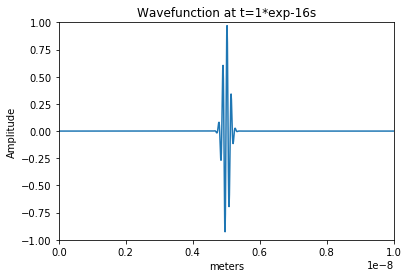

In [5]:
# Plot the wavefunction for t=1e-16 : corresponds to Tf/len(wave)*1e-16
plot(np.linspace(0,1e-8,1000),wave[int(Tf/len(wave)*1e-16)])
xlabel('meters')
ylabel('Amplitude')
xlim(0,1e-8)
ylim(-1,1)
title('Wavefunction at t=1*exp-16s')
show()

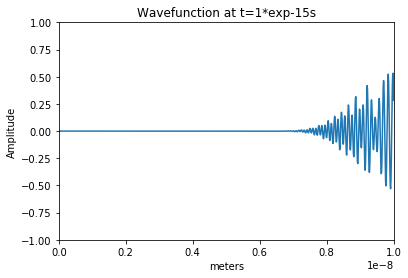

In [6]:
# Plot the wavefunction for t=1e-15 : corresponds to Tf (last element of wave)
plot(np.linspace(0,1e-8,1000),wave[-1])
xlabel('meters')
ylabel('Amplitude')
xlim(0,1e-8)
ylim(-1,1)
title('Wavefunction at t=1*exp-15s')
show()

# Animation (Part B)

Now we'll do something fun - instead of looking at fixed plots as above, let's animate the wavefunction (real part) evolution and watch it move! Do do this, note that above we appended the position array for each time to a master list called $\texttt{wave}$. Here we will use the animation package in matplotlib to cycle through indices and plot each array, thus creating a smooth movie of the vibrating string. Run the code below and enjoy!

In [7]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


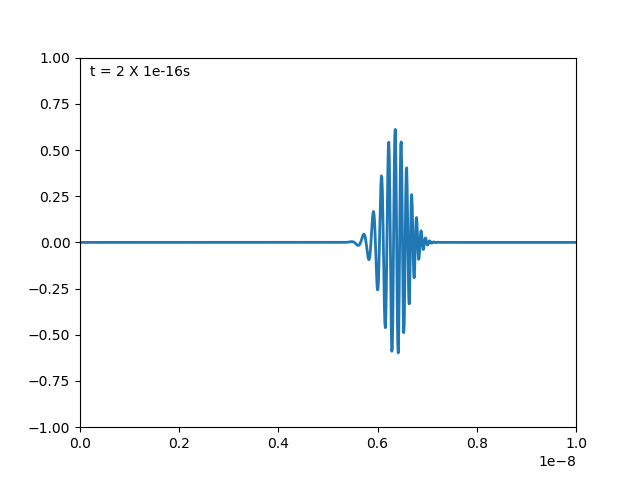

In [8]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = figure()
ax = axes(xlim=(0, max(x)), ylim=(-1,1)) # set axes
line, = ax.plot([], [], lw=2) # define the line we will plot
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes) # include time label

# initialization function: plot the background of each frame
def init():
    line.set_data([], []) # initialize line
    time_text.set_text('') # initialize time label
    return line,

# animation function.  This is called sequentially, looping with i
# On each increment, call each i*100th element of wave (to go faster)
def animate(i):
    line.set_data(x, wave[i*3]) # plot every 3 time steps
    time_text.set_text('t = ' + str(int(i*3/100)) + ' X 1e-16s') # time label
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=15, blit=False)

show() # Enjoy!

We can see the wave-packet initially propagating to the right as time goes on. When it reaches the the boundary $(x=L)$, our boundary condition $\psi(L)=0$ means that it "reflects" just like a physical wave would. The wave packet thus "bounces back" to other side, interfering with itself on the way over, and will eventually disperse / spread out.